In [28]:
!mkdir -p data
!wget --no-check-certificate 'https://drive.google.com/u/2/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download' -O data/test_data.tar.gz

--2023-11-18 01:32:51--  https://drive.google.com/u/2/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download
Resolving drive.google.com (drive.google.com)... 142.250.179.238, 2a00:1450:4009:81d::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download [following]
--2023-11-18 01:32:52--  https://drive.google.com/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/btrgsmv8rj4s1hk0ommqtbve2h6olpcu/1700271150000/03061924325282805644/*/1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-?e=download&uuid=0568f9c1-0662-40ac-bf32-b4c2739d9b2a [following]
--2023-11-18 01:33:00--  https://doc-0o-08-docs.googleusercontent.com/docs/se

In [29]:
!tar -xzvf data/test_data.tar.gz --directory data
!ls -ltrh data

Doherty_example.pickled


total 114M
-rw-r--r-- 1 ayush ayush 110M Jun 18  2021 Doherty_example.pickled
-rw-r--r-- 1 ayush ayush 3.9M Jun 18  2021 test_data.tar.gz


In [30]:
import torch
import mgplvm as mgp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
from scipy.stats import poisson

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import train_test_split

In [31]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb'))
fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': 25}
Y = fit_data['Y']
locs = fit_data['locs']
ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)
print(vels.shape)

(70482, 2)


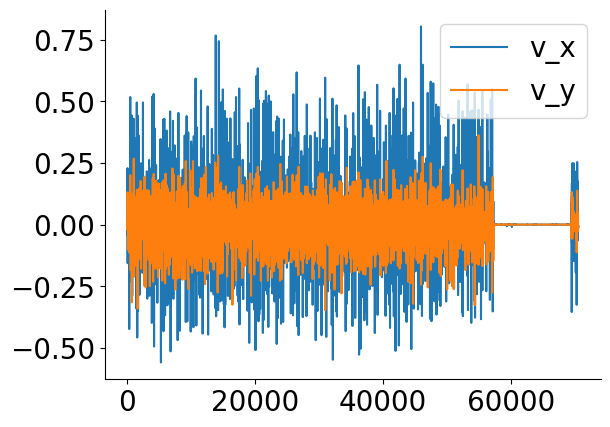

In [32]:
x = np.arange(vels.shape[0])
v_x = vels[:,0]
v_y = vels[:,1]
plt.plot(x, v_x, label='v_x')
plt.plot(x, v_y, label='v_y')
plt.legend()
plt.show()

0.0875**2 * RBF(length_scale=2.78)
2927.470375358721
0.8080459187260018


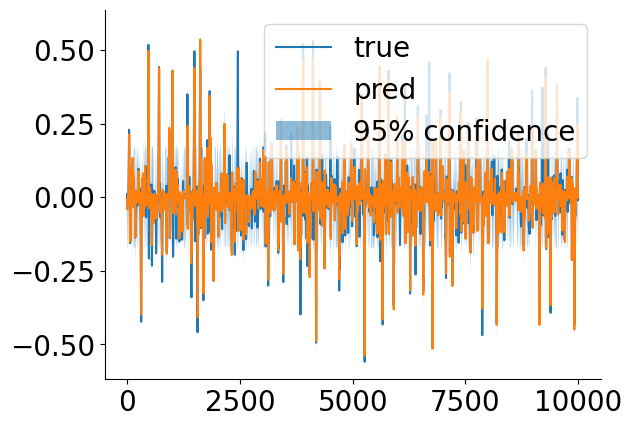

0.0938**2 * Matern(length_scale=13.3, nu=0.5)
2866.8105273353976
0.8134137292315391


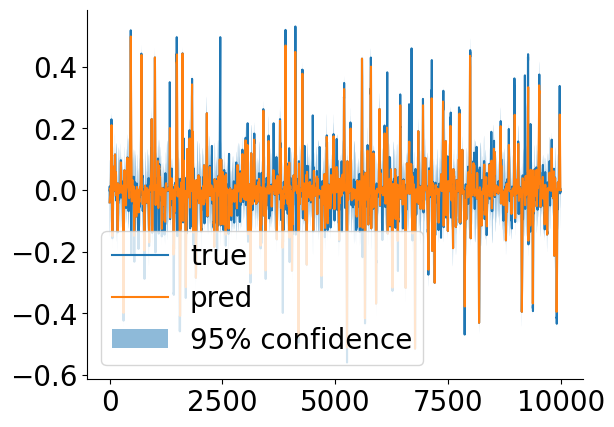

0.0995**2 * Matern(length_scale=7.51, nu=1.5)
3243.4295272781137
0.850673243696922


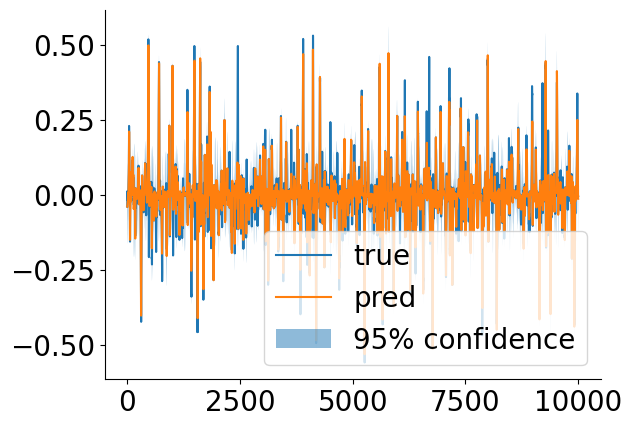

0.0966**2 * RationalQuadratic(alpha=0.686, length_scale=4.22)
3200.457234262105
0.8512052558430105


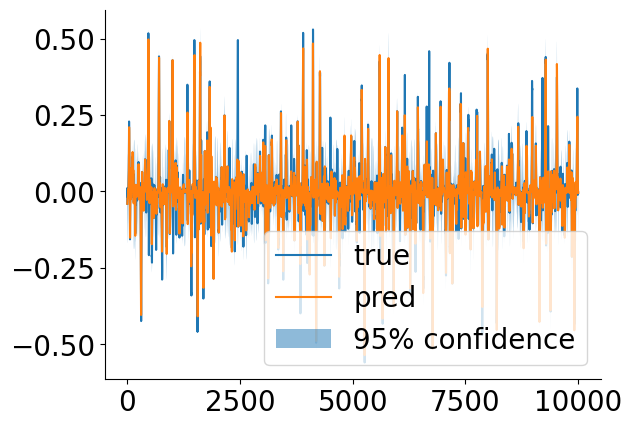

In [34]:
# kernels = [RationalQuadratic(alpha=1, length_scale=1, length_scale_bounds=(1e-1, 10)), ]
# train_len = 50
# test_len = 100
# train_x = x[:train_len]
# train_v_x = v_x[:train_len]
# test_x = x[train_len:test_len+train_len]
# test_v_x = v_x[train_len:test_len+train_len]
# total_x = np.concatenate([train_x, test_x])
# total_v_x = np.concatenate([train_v_x, test_v_x])

total_x = x[:10000]
total_v_x = v_x[:10000]
# train_x = total_x[::2]
# train_v_x = total_v_x[::2]
# test_x = total_x[1::2]
# test_v_x = total_v_x[1::2]
train_x, test_x, train_v_x, test_v_x = train_test_split(total_x, total_v_x, test_size=0.8, random_state=0)


kernels = [1*RBF(length_scale=1, length_scale_bounds=(1e-5, 50)), 1*Matern(nu=0.5, length_scale=1, length_scale_bounds=(1e-5, 100)), 1*Matern(nu=1.5, length_scale=1, length_scale_bounds=(1e-5, 100)), 1*RationalQuadratic(length_scale=1, length_scale_bounds=(1e-5, 50))]
for i, kernel in enumerate(kernels):
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(train_x.reshape(-1,1), train_v_x.reshape(-1,1))
    print(gpr.kernel_)
    print(gpr.log_marginal_likelihood())
    print(gpr.score(total_x.reshape(-1,1), total_v_x.reshape(-1,1)))
    plt.plot(total_x, total_v_x, label='true')
    mu, std = gpr.predict(total_x.reshape(-1,1), return_std=True)
    plt.plot(total_x, mu, label='pred')
    plt.fill_between(total_x, mu-1.96*std, mu+1.96*std, alpha=0.5, label='95% confidence')
    plt.legend()
    plt.show()


# mean, std = gpr.predict(x.reshape(-1,1), return_std=True)
# plt.plot(x, mean, label='mean')
# plt.fill_between(x, mean-std, mean+std, alpha=0.5, label='std')
# plt.legend()
# plt.show()
